# 今回の取り組み

- `correct_sequence_error`のメモリ処理をリアルデータでプロファイリングします
    - リアルデータはR10.4、BSA添加なしのBC31とBC32です

## いつものセットアップ

In [2]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [1]:
%%bash

pip uninstall -qy DAJIN2

# pip install -q -e .
pipの更新
# pip install -q -U pip
# pip install -q -U -r requirements.txt

bash: line 5: pipの更新: command not found


CalledProcessError: Command 'b'\npip uninstall -qy DAJIN2\n\n# pip install -q -e .\npip\xe3\x81\xae\xe6\x9b\xb4\xe6\x96\xb0\n# pip install -q -U pip\n# pip install -q -U -r requirements.txt\n'' returned non-zero exit status 127.

# 実験

In [3]:
from __future__ import annotations
from pathlib import Path

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report

#### # * Subset of Point mutation
#### # 50 or 10 or 01%
percent = "50"
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "misc/data/r10_barcode31.fq.gz",
    "misc/data/r10_barcode32.fq.gz",
    "misc/data/tyr_control.fasta",
    "single-r10",
    "mm10",
    True,
    30,
)


######################################################################
# Preprocessing
######################################################################

print(f"processing {NAME}...")

# ====================================================================
# Varidate inputs
# ====================================================================

preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

SUBDIRS = ["cache", "fasta", "sam", "midsv", "midsv_corrected", "report", "result", "mutation_loci"]
preprocess.format_inputs.make_directories(TEMPDIR, SUBDIRS, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single-r10...


In [ ]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################

import random
import re
from collections import Counter, defaultdict
from typing import Generator
import json
from pathlib import Path


def _sampling_cssplits(midsv_sample: dict[list[str, str]], mutation_loci: dict[str, set[int]]) -> list[dict[Counter]]:
    sampling = [defaultdict(list) for _ in range(len(mutation_loci))]
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == len(mutation_loci) - 1:
                break
            if idx_seq == 0:
                one_prior = cs
                continue
            if idx_seq == 1:
                two_prior = cs
                continue
            if cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                prev_cs = one_prior + "," + two_prior
                sampling[idx_seq][prev_cs].append(cs)
            one_prior, two_prior = two_prior, cs
    sampling_cssplits = []
    for samp in sampling:
        samp_counter = dict()
        for key, val in samp.items():
            val = Counter(val)
            samp_counter.update({key: val})
        sampling_cssplits.append(samp_counter)
    return sampling_cssplits


def _correct_errors(midsv_sample, mutation_loci, sampling_cssplits) -> Generator[dict[str, str]]:
    random.seed(1)
    for samp in midsv_sample:
        qname = samp["QNAME"]
        cssplits = samp["CSSPLIT"].split(",")
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == len(mutation_loci) - 1:
                break
            if idx_seq == 0:
                one_prior = cs
                continue
            if idx_seq == 1:
                two_prior = cs
                continue
            if not (cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs)):
                prev_cs = f"{one_prior},{two_prior}"
                try:
                    sampling = sampling_cssplits[idx_seq][prev_cs]
                    cssplits[idx_seq] = random.choices(*zip(*sampling.items()))[0]
                except KeyError:
                    cssplits[idx_seq] = "N"
            one_prior, two_prior = two_prior, cs
        cssplits_joined = ",".join(cssplits)
        yield {"QNAME": qname, "CSSPLIT": cssplits_joined}


def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)


def write_midsv(filepath, data) -> None:
    with open(filepath, "wt", encoding="ascii") as f:
        for d in data:
            f.write(json.dumps(d) + "\n")


###############################################################################
# main
###############################################################################


def correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
        # Extract mutation loci
        mutation_loci = MUTATION_LOCI_ALLELES[allele]
        # Correct sequence errors
        sampling_sample = _sampling_cssplits(read_midsv(filepath_sample), mutation_loci)
        sampling_control = _sampling_cssplits(read_midsv(filepath_control), mutation_loci)
        midsv_corected_sample = _correct_errors(read_midsv(filepath_sample), mutation_loci, sampling_sample)
        midsv_corected_control = _correct_errors(read_midsv(filepath_control), mutation_loci, sampling_control)
        # Output corrected midsv
        filepath_sample = Path(TEMPDIR, "midsv_corrected", f"{SAMPLE_NAME}_{allele}.json")
        filepath_control = Path(TEMPDIR, "midsv_corrected", f"{CONTROL_NAME}_{allele}.json")
        write_midsv(filepath_sample, midsv_corected_sample)
        write_midsv(filepath_control, midsv_corected_control)


###############################################################################

if __name__ == '__main__':
    # 引数
    from DAJIN2.core import (classification, clustering, consensus, preprocess, report)
    from pathlib import Path
    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    # midsv_sample, midsv_control = prepare_samples()
    # print(f"Read number: {len(midsv_control['control'])}")
    import pickle
    MUTATION_LOCI_ALLELES = pickle.load(open(f"DAJINResults/.tempdir/single-r10/mutation_loci/{SAMPLE_NAME}.plk", "rb"))
    print("execute...")
    correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES)

In [ ]:
%%bash
export PYTHONPATH=src
time mprof run tmp_memory_profile.py

In [ ]:
! mprof plot -o tmp_image.png --backend agg

- 12GBも消費しているので、これは使えないですね…

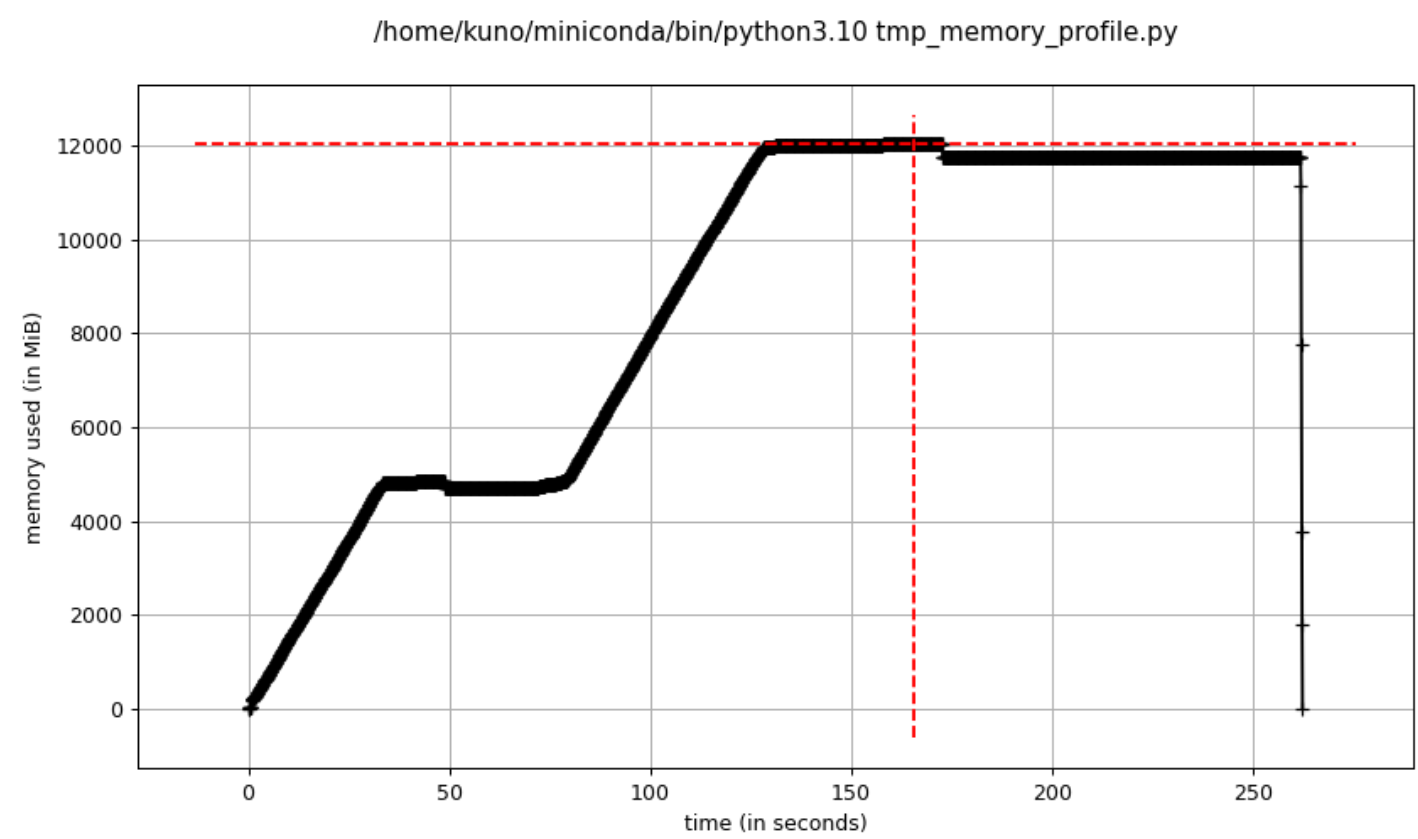

- ダウンサンプリングをして、具体的にどこが負担なのかを調べます

In [ ]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################

import random
import re
from collections import Counter, defaultdict
from typing import Generator
import json
from pathlib import Path

def _sampling_cssplits(midsv_sample: dict[list[str, str]], mutation_loci: dict[str, set[int]]) -> list[dict[Counter]]:
    sampling = [defaultdict(list) for _ in range(len(mutation_loci))]
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == len(mutation_loci) - 1:
                break
            if idx_seq == 0:
                one_prior = cs
                continue
            if idx_seq == 1:
                two_prior = cs
                continue
            if cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                prev_cs = one_prior + "," + two_prior
                sampling[idx_seq][prev_cs].append(cs)
            one_prior, two_prior = two_prior, cs
    sampling_cssplits = []
    for samp in sampling:
        samp_counter = dict()
        for key, val in samp.items():
            val = Counter(val)
            samp_counter.update({key: val})
        sampling_cssplits.append(samp_counter)
    return sampling_cssplits


def _correct_errors(midsv_sample, mutation_loci, sampling_cssplits) -> Generator[dict[str, str]]:
    random.seed(1)
    for samp in midsv_sample:
        qname = samp["QNAME"]
        cssplits = samp["CSSPLIT"].split(",")
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == len(mutation_loci) - 1:
                break
            if idx_seq == 0:
                one_prior = cs
                continue
            if idx_seq == 1:
                two_prior = cs
                continue
            if not (cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs)):
                prev_cs = f"{one_prior},{two_prior}"
                try:
                    sampling = sampling_cssplits[idx_seq][prev_cs]
                    cssplits[idx_seq] = random.choices(*zip(*sampling.items()))[0]
                except KeyError:
                    cssplits[idx_seq] = "N"
            one_prior, two_prior = two_prior, cs
        cssplits_joined = ",".join(cssplits)
        yield {"QNAME": qname, "CSSPLIT": cssplits_joined}


# ! Read 1000 lines
def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            yield json.loads(line)
            if i == 1000:
                break


def write_midsv(filepath, data) -> None:
    with open(filepath, "wt", encoding="utf-8") as f:
        for d in data:
            f.write(json.dumps(d) + "\n")


###############################################################################
# main
###############################################################################

@profile
def correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
        # Extract mutation loci
        mutation_loci = MUTATION_LOCI_ALLELES[allele]
        # Correct sequence errors
        print("sampling_sample", file = sys.stderr)
        sampling_sample = _sampling_cssplits(read_midsv(filepath_sample), mutation_loci)
        print("sampling_control", file = sys.stderr)
        sampling_control = _sampling_cssplits(read_midsv(filepath_control), mutation_loci)
        print("correct_sample", file = sys.stderr)
        midsv_corected_sample = _correct_errors(read_midsv(filepath_sample), mutation_loci, sampling_sample)
        print("correct_control", file = sys.stderr)
        midsv_corected_control = _correct_errors(read_midsv(filepath_control), mutation_loci, sampling_control)
        # Output corrected midsv
        print("Output files", file = sys.stderr)
        filepath_sample = Path(TEMPDIR, "midsv_corrected", f"{SAMPLE_NAME}_{allele}.json")
        filepath_control = Path(TEMPDIR, "midsv_corrected", f"{CONTROL_NAME}_{allele}.json")
        write_midsv(filepath_sample, midsv_corected_sample)
        write_midsv(filepath_control, midsv_corected_control)


###############################################################################

if __name__ == '__main__':
    # 引数
    from DAJIN2.core import preprocess
    from pathlib import Path
    import sys
    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    # midsv_sample, midsv_control = prepare_samples()
    # print(f"Read number: {len(midsv_control['control'])}")
    import pickle
    MUTATION_LOCI_ALLELES = pickle.load(open(f"DAJINResults/.tempdir/single-r10/mutation_loci/{SAMPLE_NAME}.plk", "rb"))
    print("execute...", file=sys.stderr)
    correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES)

In [ ]:
%%bash
export PYTHONPATH=src
time mprof run tmp_memory_profile.py > tmp_memory_profile.txt
mprof plot -o tmp_image.png --backend agg
cat tmp_memory_profile.txt

- 1000リードにダウンサンプリングしました
    - いまいちどこの関数でピークを迎えるのかわかりません

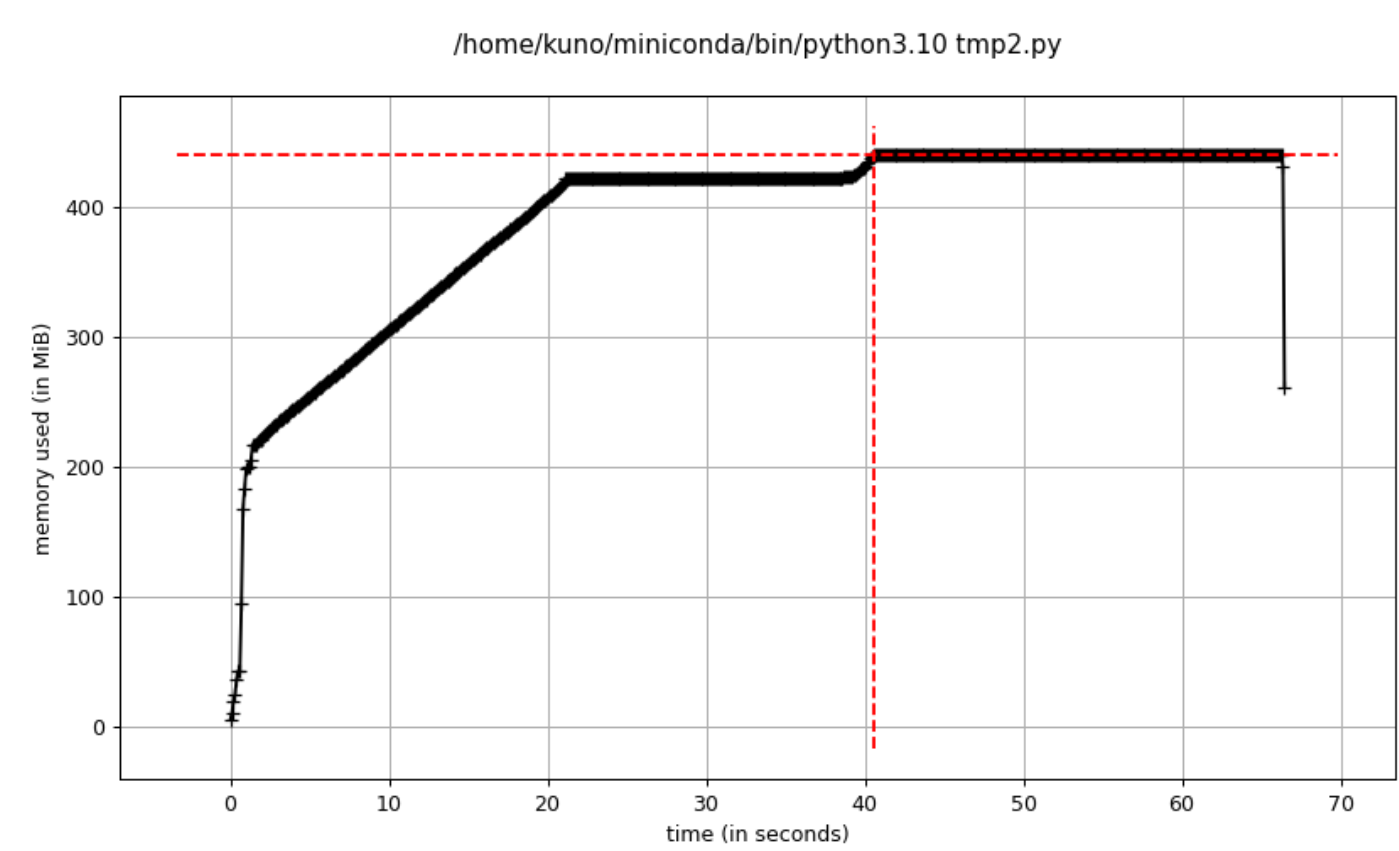

In [ ]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################

import random
import re
from collections import Counter, defaultdict
from typing import Generator
import json
from pathlib import Path

def _sampling_cssplits(midsv_sample: dict[list[str, str]], mutation_loci: dict[str, set[int]]) -> list[dict[Counter]]:
    sampling = [defaultdict(list) for _ in range(len(mutation_loci))]
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == len(mutation_loci) - 1:
                break
            if idx_seq == 0:
                one_prior = cs
                continue
            if idx_seq == 1:
                two_prior = cs
                continue
            if cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                prev_cs = one_prior + "," + two_prior
                sampling[idx_seq][prev_cs].append(cs)
            one_prior, two_prior = two_prior, cs
    sampling_cssplits = []
    for samp in sampling:
        samp_counter = dict()
        for key, val in samp.items():
            val = Counter(val)
            samp_counter.update({key: val})
        sampling_cssplits.append(samp_counter)
    return sampling_cssplits


def _correct_errors(midsv_sample, mutation_loci, sampling_cssplits) -> Generator[dict[str, str]]:
    random.seed(1)
    for samp in midsv_sample:
        qname = samp["QNAME"]
        cssplits = samp["CSSPLIT"].split(",")
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == len(mutation_loci) - 1:
                break
            if idx_seq == 0:
                one_prior = cs
                continue
            if idx_seq == 1:
                two_prior = cs
                continue
            if not (cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs)):
                prev_cs = f"{one_prior},{two_prior}"
                try:
                    sampling = sampling_cssplits[idx_seq][prev_cs]
                    cssplits[idx_seq] = random.choices(*zip(*sampling.items()))[0]
                except KeyError:
                    cssplits[idx_seq] = "N"
            one_prior, two_prior = two_prior, cs
        cssplits_joined = ",".join(cssplits)
        yield {"QNAME": qname, "CSSPLIT": cssplits_joined}


# ! Read 10000 lines
def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            yield json.loads(line)
            if i == 10000:
                break

###############################################################################
# main
###############################################################################

from time import perf_counter

def correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES) -> None:
    now = perf_counter()
    for allele in FASTA_ALLELES:
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
        # Extract mutation loci
        mutation_loci = MUTATION_LOCI_ALLELES[allele]
        # print(f"{round(perf_counter() - now, 1)} sampling_sample", file=sys.stderr)
        sampling_sample = _sampling_cssplits(read_midsv(filepath_sample), mutation_loci)

###############################################################################

if __name__ == "__main__":
    # 引数
    from DAJIN2.core import preprocess
    from pathlib import Path
    import sys

    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    # midsv_sample, midsv_control = prepare_samples()
    # print(f"Read number: {len(midsv_control['control'])}")
    import pickle

    MUTATION_LOCI_ALLELES = pickle.load(open(f"DAJINResults/.tempdir/single-r10/mutation_loci/{SAMPLE_NAME}.plk", "rb"))
    print("execute...", file=sys.stderr)
    correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES)


In [ ]:
%%bash
export PYTHONPATH=src
time mprof run tmp_memory_profile.py > tmp_memory_profile.txt
mprof plot -o tmp_image.png --backend agg
cat tmp_memory_profile.txt

- `_sampling_cssplits`以外をコメントアウトしたところ、変わらずにメモリ使用量は増加していました
    - やはり`_sampling_cssplits`のところで膨大なメモリを消費しているようです
    - `_correct_errors`のところはプラトーになっています

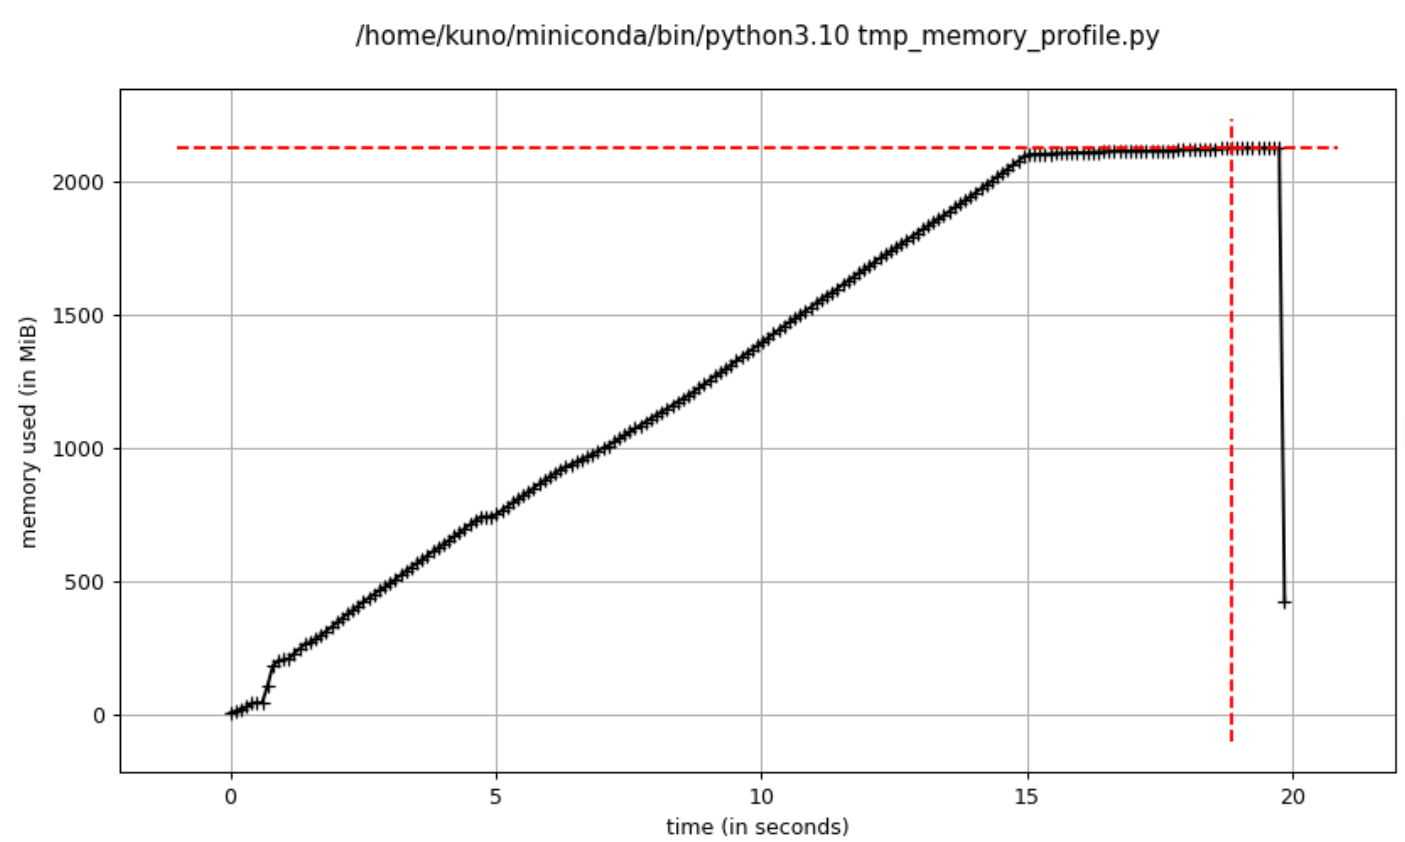

- `_sampling_cssplits`のテストコードを書きます

- `_sampling_cssplits`を縦持ち（塩基位置ごとのCSSPLITS）にすることで、1塩基位置ずつyieldする形にしたいです

In [ ]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################

import random
import re
from collections import Counter, defaultdict
from typing import Generator
import json
from pathlib import Path

def _sampling_cssplits(midsv_sample: dict[list[str, str]], mutation_loci: dict[str, set[int]]) -> list[dict[Counter]]:
    sampling = [defaultdict(list) for _ in range(len(mutation_loci))]
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == len(mutation_loci) - 1:
                break
            if idx_seq == 0:
                one_prior = cs
                continue
            if idx_seq == 1:
                two_prior = cs
                continue
            if cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                prev_cs = one_prior + "," + two_prior
                sampling[idx_seq][prev_cs].append(cs)
            one_prior, two_prior = two_prior, cs
    for samp in sampling:
        samp_counter = dict()
        for key, val in samp.items():
            val = Counter(val)
            samp_counter.update({key: val})
        yield samp_counter


# ! Read 10000 lines
def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            yield json.loads(line)
            if i == 10000:
                break

###############################################################################
# main
###############################################################################

from time import perf_counter

def correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES) -> None:
    now = perf_counter()
    for allele in FASTA_ALLELES:
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
        # Extract mutation loci
        mutation_loci = MUTATION_LOCI_ALLELES[allele]
        # print(f"{round(perf_counter() - now, 1)} sampling_sample", file=sys.stderr)
        sampling_sample = _sampling_cssplits(read_midsv(filepath_sample), mutation_loci)

###############################################################################

if __name__ == "__main__":
    # 引数
    from DAJIN2.core import preprocess
    from pathlib import Path
    import sys

    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    # midsv_sample, midsv_control = prepare_samples()
    # print(f"Read number: {len(midsv_control['control'])}")
    import pickle

    MUTATION_LOCI_ALLELES = pickle.load(open(f"DAJINResults/.tempdir/single-r10/mutation_loci/{SAMPLE_NAME}.plk", "rb"))
    print("execute...", file=sys.stderr)
    correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES)


In [ ]:
%%bash
export PYTHONPATH=src
time mprof run tmp_memory_profile.py > tmp_memory_profile.txt
mprof plot -o tmp_image.png --backend agg
cat tmp_memory_profile.txt

- とりあえず`_sampling_cssplits`の出力を`yield`にしたところ、`200MB`まで下がりました

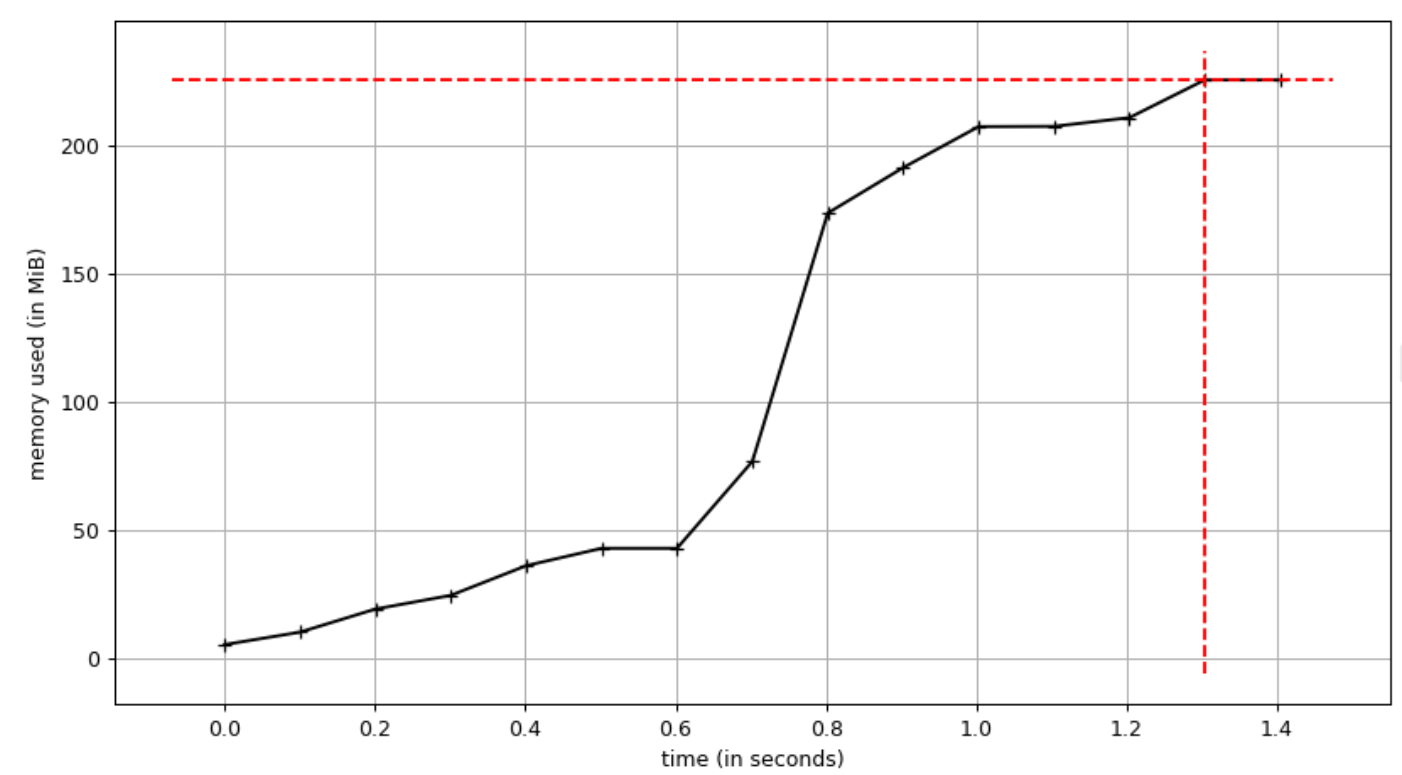

In [ ]:
from __future__ import annotations

import random
import re
from collections import Counter, defaultdict
from typing import Generator
import json
from pathlib import Path

def _sampling_cssplits(midsv_sample: dict[list[str, str]], mutation_loci: dict[str, set[int]]) -> list[dict[Counter]]:
    sampling = [defaultdict(list) for _ in range(len(mutation_loci))]
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == len(mutation_loci) - 1:
                break
            if idx_seq == 0:
                one_prior = cs
                continue
            if idx_seq == 1:
                two_prior = cs
                continue
            if cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                prev_cs = one_prior + "," + two_prior
                sampling[idx_seq][prev_cs].append(cs)
            one_prior, two_prior = two_prior, cs
    for samp in sampling:
        samp_counter = dict()
        for key, val in samp.items():
            val = Counter(val)
            samp_counter.update({key: val})
        yield samp_counter

In [ ]:
import pickle
allele = "control"
MUTATION_LOCI_ALLELES = pickle.load(open(f"DAJINResults/.tempdir/single-r10/mutation_loci/{SAMPLE_NAME}.plk", "rb"))

def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            yield json.loads(line)
            if i == 100:
                break

mutation_loci = MUTATION_LOCI_ALLELES[allele]
filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
sampling_sample = _sampling_cssplits(read_midsv(filepath_sample), mutation_loci)

In [ ]:
print(next(sampling_sample))
print(next(sampling_sample))
print(next(sampling_sample))

- `_sampling_cssplits`をgeneratorにしたことによって、`_correct_errors`では縦持ちにする必要がありそうです

- はじめに各リードを3merごとに分割して持っておくと便利かも

In [ ]:
# generate 3 mer by reads
def generate_kmer_by_reads(midsv_sample: dict[list[str, str]], mutation_loci: dict[str, set[int]]) -> Generator[str]:
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        cssplits_kmer = []
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == len(mutation_loci) - 1:
                break
            if idx_seq == 0:
                two_prior = cs
                cssplits_kmer.append("")
                continue
            if idx_seq == 1:
                one_prior = cs
                cssplits_kmer.append("")
                continue
            cssplits_kmer.append(two_prior + "," + one_prior + "," + cs)
            two_prior, one_prior = one_prior, cs
        yield cssplits_kmer

In [ ]:
def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            yield json.loads(line)
            if i == 10000:
                break

In [ ]:
filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")

In [ ]:
x = generate_kmer_by_reads(read_midsv(filepath_sample), mutation_loci)
print(next(x))
print(next(x))
print(next(x))

In [ ]:
midsv_3mer_sample = generate_kmer_by_reads(read_midsv(filepath_sample), mutation_loci)
midsv_3mer_sample_t = zip(*midsv_3mer_sample)
print(next(midsv_3mer_sample_t))
print(next(midsv_3mer_sample_t))
print(next(midsv_3mer_sample_t))

In [ ]:
midsv_3mer_sample = generate_kmer_by_reads(read_midsv(filepath_sample), mutation_loci)
sampling_cssplits = []
for idx_seq, cssplits_3mers in enumerate(zip(*midsv_3mer_sample)):
    sample_2mer = defaultdict(list)
    if idx_seq == 0 or idx_seq == 1:
        sampling_cssplits.append(sample_2mer)
        continue
    for cssplits_3mer in cssplits_3mers:
        two_prior, one_prior, cs = cssplits_3mer.split(",")
        if cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
            prev_2mer = two_prior + "," + one_prior
            sample_2mer[prev_2mer].append(cs)
        one_prior, two_prior = two_prior, cs
    sample_2mer_counted = {mer: Counter(samp) for mer, samp in sample_2mer.items()}
    sampling_cssplits.append(sample_2mer_counted)

In [ ]:
print(sampling_cssplits[:3])
print(len(sampling_cssplits))
print(len(mutation_loci))

In [ ]:
seq = [["A", "C", "G", "T"], ["A", "A", "A", "A"]]
print(seq)
seq_t = list(zip(*seq))
print(seq_t)
seq_r = list(zip(*seq_t))
print(seq_r)

In [ ]:
def _correct_errors(midsv_sample: Generator, mutation_loci: list(set(str)), sampling_cssplits: list(defaultdict(Counter))) -> Generator[dict[str, str]]:
    random.seed(1)
    for samp in midsv_sample:
        qname = samp["QNAME"]
        cssplits = samp["CSSPLIT"].split(",")
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == len(mutation_loci) - 1:
                break
            if idx_seq == 0:
                two_prior = cs
                continue
            if idx_seq == 1:
                one_prior = cs
                continue
            if not (cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs)):
                previous_2mer = f"{two_prior},{one_prior}"
                sampling = sampling_cssplits[idx_seq][previous_2mer]
                if sampling == Counter():
                    cssplits[idx_seq] = "N"
                    continue
                cssplits[idx_seq] = random.choices(*zip(*sampling.items()))[0]
            two_prior, one_prior = one_prior, cs
        cssplits_joined = ",".join(cssplits)
        yield {"QNAME": qname, "CSSPLIT": cssplits_joined}

In [ ]:
x = _correct_errors(read_midsv(filepath_sample), mutation_loci, sampling)

In [ ]:
print(next(x))

In [ ]:
mutation_loci[:3]

- `_sampling_cssplits`において、`sampling = [defaultdict(list) for _ in range(len(mutation_loci))]`だと膨大なメモリが必要になるので、シンプルに`sampling_cssplits = []`とすることにしました

- メモリ使用量をプロファイルします

In [ ]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################

import random
import re
from collections import Counter, defaultdict
from typing import Generator
import json
from pathlib import Path

# generate 3 mer by reads
def _generate_kmer_by_reads(midsv_sample: dict[list[str, str]], mutation_loci: dict[str, set[int]]) -> Generator[str]:
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        cssplits_kmer = []
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == len(mutation_loci) - 1:
                break
            if idx_seq == 0:
                two_prior = cs
                cssplits_kmer.append("")
                continue
            if idx_seq == 1:
                one_prior = cs
                cssplits_kmer.append("")
                continue
            cssplits_kmer.append(two_prior + "," + one_prior + "," + cs)
            two_prior, one_prior = one_prior, cs
        yield cssplits_kmer

def _sampling_cssplits(midsv_sample, mutation_loci):
    midsv_3mer_sample = _generate_kmer_by_reads(midsv_sample, mutation_loci)
    sampling_cssplits = []
    for idx_seq, cssplits_3mers in enumerate(zip(*midsv_3mer_sample)):
        sample_2mer = defaultdict(Counter)
        if idx_seq == 0 or idx_seq == 1:
            sampling_cssplits.append(sample_2mer)
            continue
        for cssplits_3mer in cssplits_3mers:
            two_prior, one_prior, cs = cssplits_3mer.split(",")
            if cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                prev_2mer = two_prior + "," + one_prior
                sample_2mer[prev_2mer] += Counter([cs])
            one_prior, two_prior = two_prior, cs
        sampling_cssplits.append(sample_2mer)
    return sampling_cssplits


# ! Read 10000 lines
def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            yield json.loads(line)
            if i == 10000:
                break

###############################################################################
# main
###############################################################################

from time import perf_counter

def correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES) -> None:
    now = perf_counter()
    for allele in FASTA_ALLELES:
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
        # Extract mutation loci
        mutation_loci = MUTATION_LOCI_ALLELES[allele]
        # print(f"{round(perf_counter() - now, 1)} sampling_sample", file=sys.stderr)
        sampling_sample = _sampling_cssplits(read_midsv(filepath_sample), mutation_loci)

###############################################################################

if __name__ == "__main__":
    # 引数
    from DAJIN2.core import preprocess
    from pathlib import Path
    import sys

    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    # midsv_sample, midsv_control = prepare_samples()
    # print(f"Read number: {len(midsv_control['control'])}")
    import pickle

    MUTATION_LOCI_ALLELES = pickle.load(open(f"DAJINResults/.tempdir/single-r10/mutation_loci/{SAMPLE_NAME}.plk", "rb"))
    print("execute...", file=sys.stderr)
    correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES)


In [ ]:
%%bash
export PYTHONPATH=src
time mprof run tmp_memory_profile.py > tmp_memory_profile.txt
mprof plot -o tmp_image.png --backend agg
cat tmp_memory_profile.txt

- 10_000の配列に対して、2GBほど消費しており、変わりませんでした
- むしろ毎回Counterを呼び出しているため、計算量が多くなっています

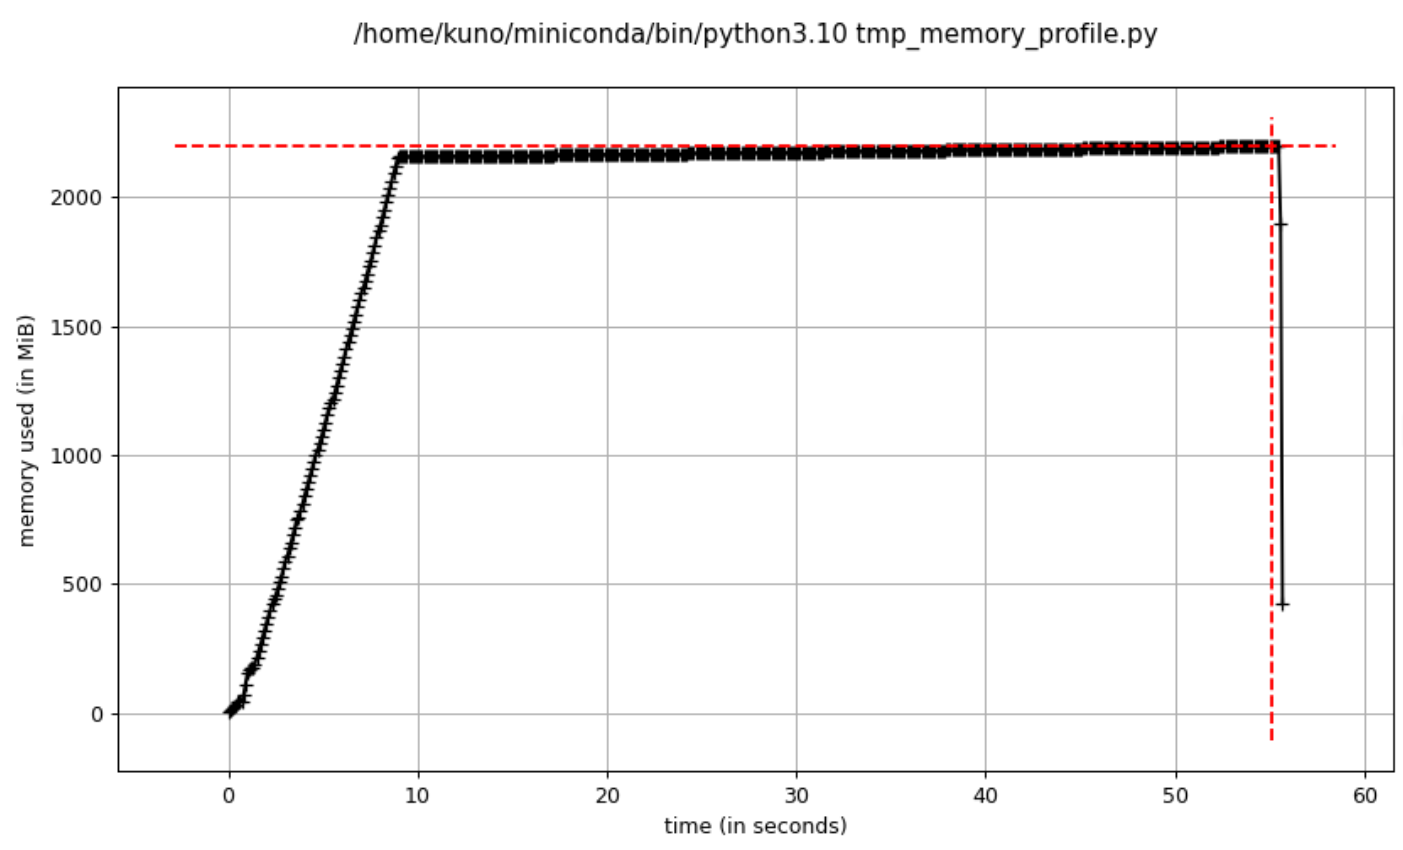

In [ ]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################

import random
import re
from collections import Counter, defaultdict
from typing import Generator
import json
from pathlib import Path

# 変更前のコード
def _sampling_cssplits(midsv_sample: dict[list[str, str]], mutation_loci: dict[str, set[int]]) -> list[dict[Counter]]:
    sampling = [defaultdict(list) for _ in range(len(mutation_loci))]
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == len(mutation_loci) - 1:
                break
            if idx_seq == 0:
                one_prior = cs
                continue
            if idx_seq == 1:
                two_prior = cs
                continue
            if cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                prev_cs = one_prior + "," + two_prior
                sampling[idx_seq][prev_cs].append(cs)
            one_prior, two_prior = two_prior, cs
    sampling_cssplits = []
    for samp in sampling:
        samp_counter = dict()
        for key, val in samp.items():
            val = Counter(val)
            samp_counter.update({key: val})
        sampling_cssplits.append(samp_counter)
    return sampling_cssplits

# ! Read 10000 lines
def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            yield json.loads(line)
            if i == 10000:
                break

###############################################################################
# main
###############################################################################

from time import perf_counter

def correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES) -> None:
    now = perf_counter()
    for allele in FASTA_ALLELES:
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
        # Extract mutation loci
        mutation_loci = MUTATION_LOCI_ALLELES[allele]
        # print(f"{round(perf_counter() - now, 1)} sampling_sample", file=sys.stderr)
        sampling_sample = _sampling_cssplits(read_midsv(filepath_sample), mutation_loci)

###############################################################################

if __name__ == "__main__":
    # 引数
    from DAJIN2.core import preprocess
    from pathlib import Path
    import sys

    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    # midsv_sample, midsv_control = prepare_samples()
    # print(f"Read number: {len(midsv_control['control'])}")
    import pickle

    MUTATION_LOCI_ALLELES = pickle.load(open(f"DAJINResults/.tempdir/single-r10/mutation_loci/{SAMPLE_NAME}.plk", "rb"))
    print("execute...", file=sys.stderr)
    correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES)


In [ ]:
%%bash
export PYTHONPATH=src
time mprof run tmp_memory_profile.py > tmp_memory_profile.txt
mprof plot -o tmp_image.png --backend agg
cat tmp_memory_profile.txt

- 10_000本のリードに対して改めて変更前の`_sampling_cssplits`を実行したところ、やはりメモリ使用量は2GBほどで変わらず、計算時間は半分以下でした😫😫😫

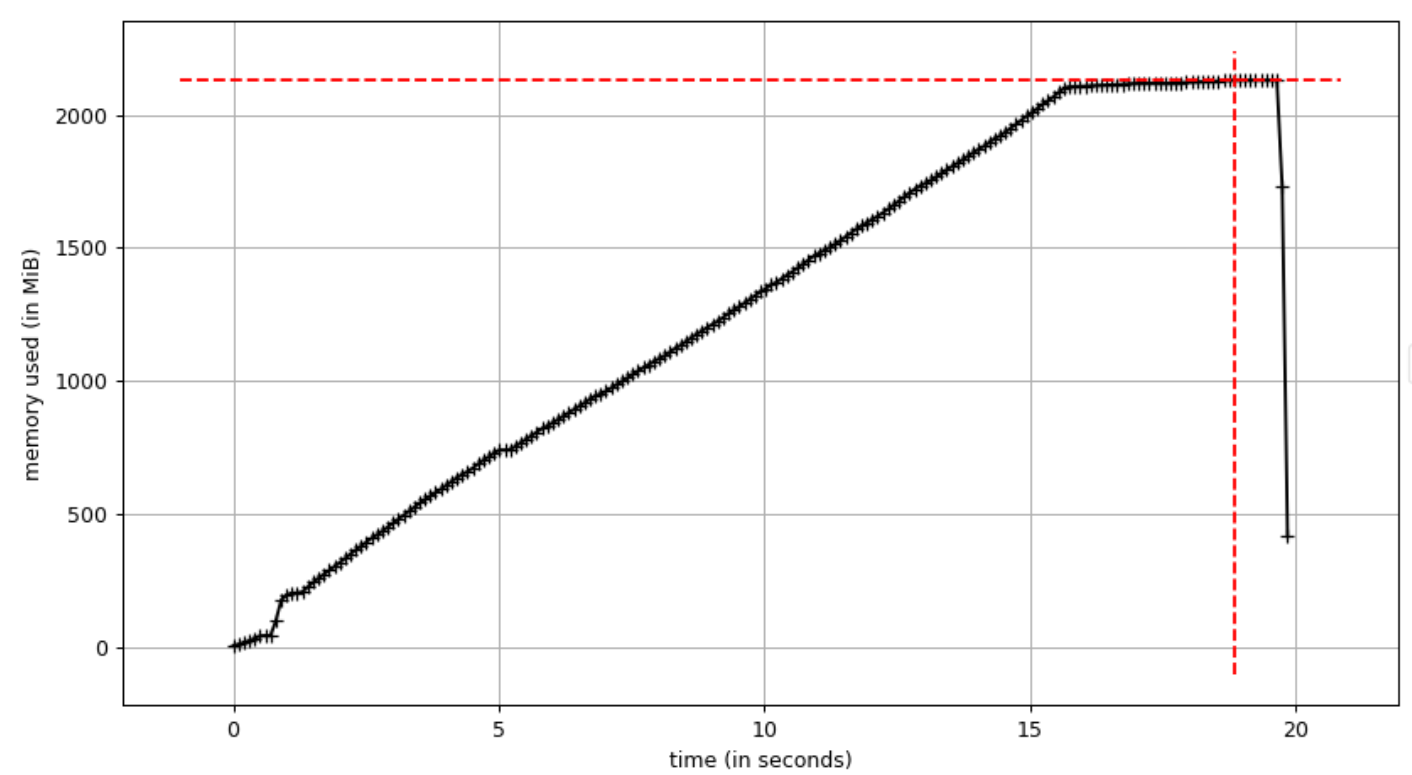

- まずは`_sampling_cssplits`において、Counterを最後に呼び指すようにします
- 次に同じく`_sampling_cssplits`において、各塩基位置ごとのCounterをyieldして取ってきます
- 続いて、転置した3merを`_correct_errors`でも行い、各塩基位置ごとの`_sampling_cssplits`と合わせます
- 最後に`_correct_errors`で出力したgeneratorを転置して、もとに戻します

In [ ]:
def _generate_3mer(midsv_sample: Generator[dict[str, str]]) -> Generator[str]:
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        cssplits_kmer = []
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == 0:
                two_prior = cs
                cssplits_kmer.append(cs)
                continue
            if idx_seq == 1:
                one_prior = cs
                cssplits_kmer.append(cs)
                continue
            cssplits_kmer.append(two_prior + "," + one_prior + "," + cs)
            two_prior, one_prior = one_prior, cs
        yield cssplits_kmer

def _sampling_cssplits(midsv_sample, mutation_loci) -> Generator:
    midsv_3mer_sample = _generate_3mer(midsv_sample)
    for idx_seq, cssplits_3mers in enumerate(zip(*midsv_3mer_sample)):
        sampling_2mer = defaultdict(list)
        if idx_seq == 0 or idx_seq == 1:
            yield defaultdict(Counter)
            continue
        for cssplits_3mer in cssplits_3mers:
            two_prior, one_prior, cs = cssplits_3mer.split(",")
            if cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                previous_2mer = two_prior + "," + one_prior
                sampling_2mer[previous_2mer].append(cs)
            one_prior, two_prior = two_prior, cs
        yield {mer: Counter(samp) for mer, samp in sample_2mer.items()}

In [ ]:
def _correct_errors_cssplits(midsv_sample, mutation_loci, sampling_cssplits):
    random.seed(1)
    midsv_3mer = _generate_3mer(midsv_sample, mutation_loci)
    midsv_3mer_t = zip(*midsv_3mer)
    for idx_seq, (cssplits_3mers, sampling_cssplit) in enumerate(zip(midsv_3mer_t, sampling_cssplits)):
        if idx_seq == 0 or idx_seq == 1:
            yield [cs for cs in cssplits_3mers]
            continue
        cssplits_corrected = []
        for cssplits_3mer in cssplits_3mers:
            two_prior, one_prior, cs = cssplits_3mer.split(",")
            if not (cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs)):
                previous_2mer = f"{two_prior},{one_prior}"
                try:
                    sampling = sampling_cssplit[previous_2mer]
                except KeyError:
                    cs = "N"
                else:
                    cs = random.choices(*zip(*sampling.items()))[0]
            cssplits_corrected.append(cs)
        yield cssplits_corrected

In [ ]:
# ! Read 100 lines
def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            yield json.loads(line)
            if i == 100:
                break

# def count_newlines(filepath):
#     def _make_gen(reader):
#         while True:
#             b = reader(2**16)
#             if not b:
#                 break
#             yield b

#     with open(filepath, "rb") as f:
#         count = sum(buf.count(b"\n") for buf in _make_gen(f.raw.read))
#     return count

allele = "control"
filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
mutation_loci = MUTATION_LOCI_ALLELES[allele]

sampling_cssplits = _sampling_cssplits(read_midsv(filepath_sample), mutation_loci)
cssplits_corrected = _correct_errors_cssplits(read_midsv(filepath_sample), mutation_loci, sampling_cssplits)

In [ ]:
cssplits_corrected_t = zip(*cssplits_corrected)

In [ ]:
for i, cssplits in enumerate(cssplits_corrected_t):
    print(",".join(cssplits))
    if i == 3:
        break

- 良い感じにできたので、一度メモリプロファイルをします

In [ ]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################

import random
import re
from collections import Counter, defaultdict
from typing import Generator
import json
from pathlib import Path
import numpy as np

def _generate_3mer(midsv_sample: Generator[dict[str, str]]) -> Generator[str]:
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        cssplits_kmer = []
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == 0:
                two_prior = cs
                cssplits_kmer.append(cs)
                continue
            if idx_seq == 1:
                one_prior = cs
                cssplits_kmer.append(cs)
                continue
            cssplits_kmer.append(two_prior + "," + one_prior + "," + cs)
            two_prior, one_prior = one_prior, cs
        yield cssplits_kmer

def _sampling_cssplits(midsv_sample, mutation_loci) -> Generator:
    midsv_3mer_sample = _generate_3mer(midsv_sample)
    for idx_seq, cssplits_3mers in enumerate(zip(*midsv_3mer_sample)):
        yield cssplits_3mers
    # for idx_seq, cssplits_3mers in enumerate(zip(*midsv_3mer_sample)):
    #     yield cssplits_3mers
        # sampling_2mer = defaultdict(list)
        # if idx_seq == 0 or idx_seq == 1:
        #     yield defaultdict(Counter)
        #     continue
        # for cssplits_3mer in cssplits_3mers:
        #     two_prior, one_prior, cs = cssplits_3mer.split(",")
        #     if cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
        #         previous_2mer = two_prior + "," + one_prior
        #         sampling_2mer[previous_2mer].append(cs)
        #     one_prior, two_prior = two_prior, cs
        # yield {mer: Counter(samp) for mer, samp in sampling_2mer.items()}
        # del sampling_2mer


# def _correct_errors_cssplits(midsv_sample, mutation_loci, sampling_cssplits):
#     random.seed(1)
#     midsv_3mer = _generate_3mer(midsv_sample)
#     midsv_3mer_t = zip(*midsv_3mer)
#     for idx_seq, (cssplits_3mers, sampling_cssplit) in enumerate(zip(midsv_3mer_t, sampling_cssplits)):
#         if idx_seq == 0 or idx_seq == 1:
#             yield [cs for cs in cssplits_3mers]
#             continue
#         cssplits_corrected = []
#         for cssplits_3mer in cssplits_3mers:
#             two_prior, one_prior, cs = cssplits_3mer.split(",")
#             if not (cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs)):
#                 previous_2mer = f"{two_prior},{one_prior}"
#                 try:
#                     sampling = sampling_cssplit[previous_2mer]
#                 except KeyError:
#                     cs = "N"
#                 else:
#                     cs = random.choices(*zip(*sampling.items()))[0]
#             cssplits_corrected.append(cs)
#         yield cssplits_corrected

# ! Read 10000 lines
def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            yield json.loads(line)
            if i == 10000:
                break

###############################################################################
# main
###############################################################################

from time import perf_counter

def correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES) -> None:
    now = perf_counter()
    for allele in FASTA_ALLELES:
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        mutation_loci = MUTATION_LOCI_ALLELES[allele]
        # print(f"{round(perf_counter() - now, 1)} sampling_sample", file=sys.stderr)
        sampling_cssplits = _sampling_cssplits(read_midsv(filepath_sample), mutation_loci)
        _ = next(sampling_cssplits)
        # cssplits_corrected = _correct_errors_cssplits(read_midsv(filepath_sample), mutation_loci, sampling_cssplits)
        # out_filepath = Path(TEMPDIR, "midsv_corrected", f"{SAMPLE_NAME}_{allele}.json")
        # with open(out_filepath, "wt", encoding="utf-8") as f:
        #     for data in cssplits_corrected:
        #         f.write(json.dumps(data) + "\n")

###############################################################################

if __name__ == "__main__":
    # 引数
    from DAJIN2.core import preprocess
    from pathlib import Path
    import sys

    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    # midsv_sample, midsv_control = prepare_samples()
    # print(f"Read number: {len(midsv_control['control'])}")
    import pickle

    MUTATION_LOCI_ALLELES = pickle.load(open(f"DAJINResults/.tempdir/single-r10/mutation_loci/{SAMPLE_NAME}.plk", "rb"))
    print("execute...", file=sys.stderr)
    correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES)


In [ ]:
%%bash
export PYTHONPATH=src
time mprof run tmp_memory_profile.py > tmp_memory_profile.txt
mprof plot -o tmp_image.png --backend agg
cat tmp_memory_profile.txt

- 10_000本の配列に対して、4000MB (4GB)も使用していました
- 完全に予想外でした
- 一体どこでこんなにメモリを消費しているのでしょうか…

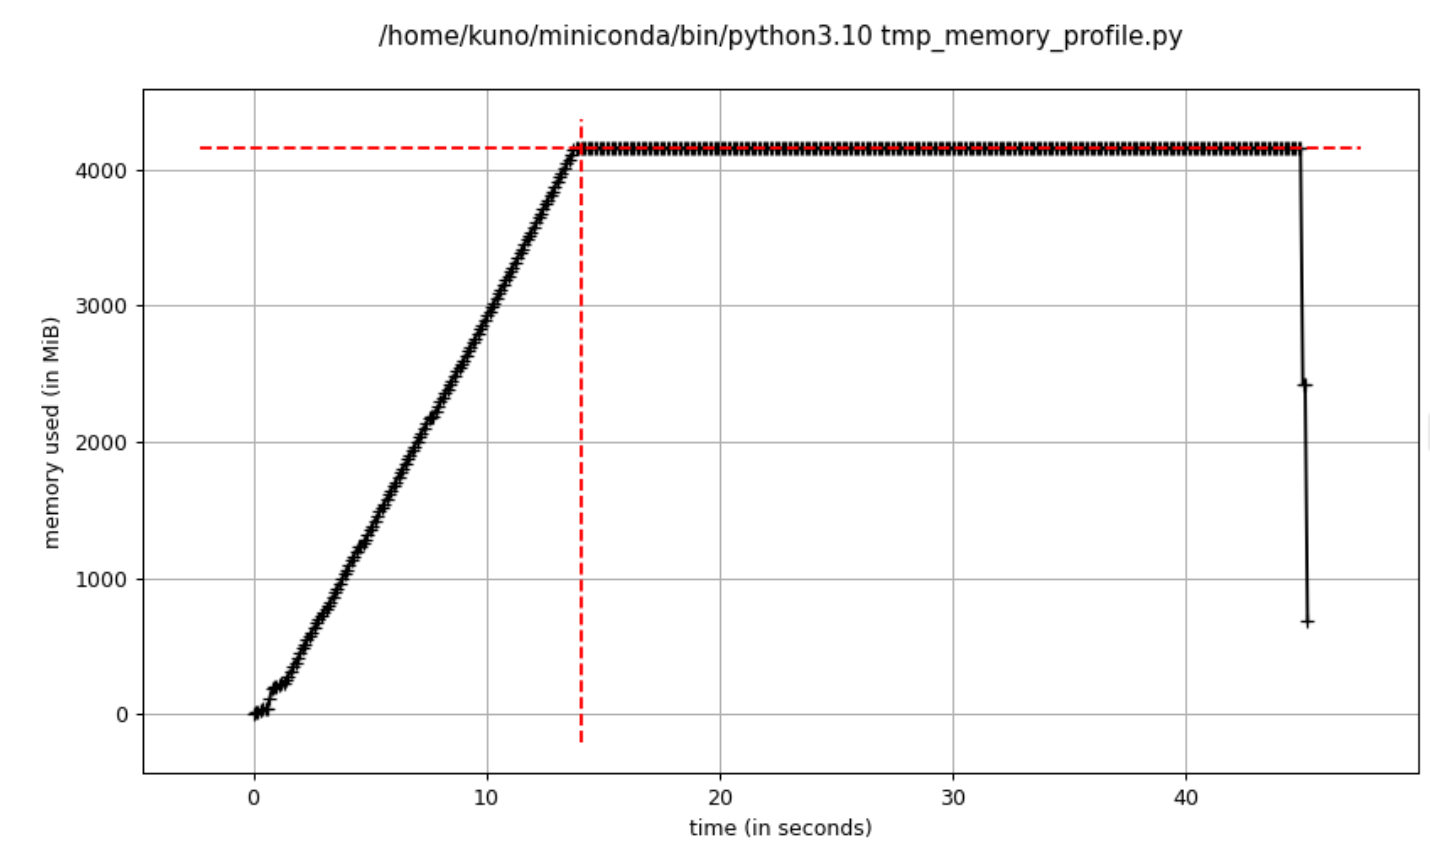

- `zip(*)`の転置のところでメモリがゴリゴリ消費されるみたいです
- メモリを使わずに転置をするのは、Pythonだけでは難しそうなのでShellの力を借りようと思います

In [ ]:

from itertools import islice
import subprocess
from pathlib import Path
import tempfile

def _generate_transposed_tsv(input_path: str, output_path: str, chunksize: int = 100) -> None:
    delimiter = "\t"
    with tempfile.NamedTemporaryFile() as fp:
        temp_output = fp.name
    with tempfile.NamedTemporaryFile() as fp:
        temp_chunk = fp.name
    with tempfile.NamedTemporaryFile() as fp:
        temp_pasted = fp.name
    with open(input_path, "r") as f:
        while True:
            next_n_lines = [line.strip().split(delimiter) for line in islice(f, chunksize)]
            if not next_n_lines:
                break
            with open(temp_chunk, "w") as out:
                for line in zip(*next_n_lines):
                    out.write(delimiter.join(line) + "\n")
            if not Path(temp_output).exists():
                subprocess.call(f"mv {temp_chunk} {temp_output}", shell=True)
            else:
                subprocess.call(f"paste -d, {temp_output} {temp_chunk} > {temp_pasted}", shell=True)
                subprocess.call(f"mv {temp_pasted} {temp_output}", shell=True)
        subprocess.call(f"mv {temp_output} {output_path}", shell=True)


# input_file = "tmp_array.csv"
# output_file = "tmp_array_transposed.csv"

# _generate_transposed_tsv(input_file, output_file)

In [ ]:
# ! Read 10000 lines
def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            yield json.loads(line)
            if i == 10000:
                break

def _generate_3mer(midsv_sample: Generator[dict[str, str]]) -> Generator[str]:
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        cssplits_kmer = []
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == 0:
                two_prior = cs
                cssplits_kmer.append(cs)
                continue
            if idx_seq == 1:
                one_prior = cs
                cssplits_kmer.append(cs)
                continue
            cssplits_kmer.append(two_prior + "," + one_prior + "," + cs)
            two_prior, one_prior = one_prior, cs
        yield cssplits_kmer


def write_cssplits_as_tsv(cssplits_3mer_sample, output_path):
    with open(output_path, "w") as out:
        for cssplits in cssplits_3mer_sample:
            out.write("\t".join(cssplits) + "\n")

def read_cssplits(input_path):
    with open(input_path, "r") as f:
        for line in f:
            yield line.split("\t")

filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
x = _generate_3mer(read_midsv(filepath_sample))
write_cssplits_as_tsv(x, "tmp_cssplits.tsv")
# sampling_cssplits = _sampling_cssplits(read_midsv(filepath_sample))

In [ ]:
_generate_transposed_tsv("tmp_cssplits.txt", "tmp_transposed.tsv", chunksize= 100)

In [ ]:
print(next(read_cssplits("tmp_transposed.tsv")))

- メモリをプロファイルします

In [ ]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################

from itertools import islice
import subprocess
from pathlib import Path
import tempfile
import random
import re
from collections import Counter, defaultdict
from typing import Generator
import json
from pathlib import Path

def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)

# # ! Read 10000 lines
# def read_midsv(filepath) -> Generator[dict[str, str]]:
#     with open(filepath, "r") as f:
#         for i, line in enumerate(f):
#             yield json.loads(line)
#             if i == 10000:
#                 break

def _generate_3mer(midsv_sample: Generator[dict[str, str]]) -> Generator[str]:
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        cssplits_kmer = []
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == 0:
                two_prior = cs
                cssplits_kmer.append(cs)
                continue
            if idx_seq == 1:
                one_prior = cs
                cssplits_kmer.append(cs)
                continue
            cssplits_kmer.append(two_prior + "," + one_prior + "," + cs)
            two_prior, one_prior = one_prior, cs
        yield cssplits_kmer


def _transpose_by_subprocess(input_path: str, output_path: str, chunksize: int = 100) -> None:
    delimiter = "\t"
    with tempfile.NamedTemporaryFile() as fp:
        temp_output = fp.name
    with tempfile.NamedTemporaryFile() as fp:
        temp_chunk = fp.name
    with tempfile.NamedTemporaryFile() as fp:
        temp_pasted = fp.name
    with open(input_path, "r") as f:
        while True:
            next_n_lines = [line.strip().split(delimiter) for line in islice(f, chunksize)]
            if not next_n_lines:
                break
            with open(temp_chunk, "w") as out:
                for line in zip(*next_n_lines):
                    out.write(delimiter.join(line) + "\n")
            if not Path(temp_output).exists():
                subprocess.call(f"mv {temp_chunk} {temp_output}", shell=True)
            else:
                subprocess.call(f"paste -d, {temp_output} {temp_chunk} > {temp_pasted}", shell=True)
                subprocess.call(f"mv {temp_pasted} {temp_output}", shell=True)
        subprocess.call(f"mv {temp_output} {output_path}", shell=True)


def _write_cssplits_as_tsv(cssplits_3mer_sample, output_path):
    with open(output_path, "w") as out:
        for cssplits in cssplits_3mer_sample:
            out.write("\t".join(cssplits) + "\n")


def _read_cssplits_as_tsv(input_path):
    with open(input_path, "r") as f:
        for line in f:
            yield line.split("\t")

###############################################################################
# main
###############################################################################

from time import perf_counter

def correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES) -> None:
    now = perf_counter()
    for allele in FASTA_ALLELES:
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        # Extract mutation loci
        mutation_loci = MUTATION_LOCI_ALLELES[allele]
        x = _generate_3mer(read_midsv(filepath_sample))
        _write_cssplits_as_tsv(x, "tmp_cssplits.tsv")
        _transpose_by_subprocess("tmp_cssplits.tsv", "tmp_transposed.tsv", chunksize=100)
        _ = next(_read_cssplits_as_tsv("tmp_transposed.tsv"))

###############################################################################

if __name__ == "__main__":
    # 引数
    from DAJIN2.core import preprocess
    from pathlib import Path
    import sys

    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    # midsv_sample, midsv_control = prepare_samples()
    # print(f"Read number: {len(midsv_control['control'])}")
    import pickle

    MUTATION_LOCI_ALLELES = pickle.load(open(f"DAJINResults/.tempdir/single-r10/mutation_loci/{SAMPLE_NAME}.plk", "rb"))
    print("execute...", file=sys.stderr)
    correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES)


In [ ]:
%%bash
export PYTHONPATH=src
time mprof run tmp_memory_profile.py > tmp_memory_profile.txt
mprof plot -o tmp_image.png --backend agg
cat tmp_memory_profile.txt

- `shell`の力を借りて、転置のメモリ使用量を最小限にすることができました！
    - `paste`コマンドが強力すぎました
- 計算時間はかかりますが、OMM Killerになるよりかはマシですので、これで進めようと思います

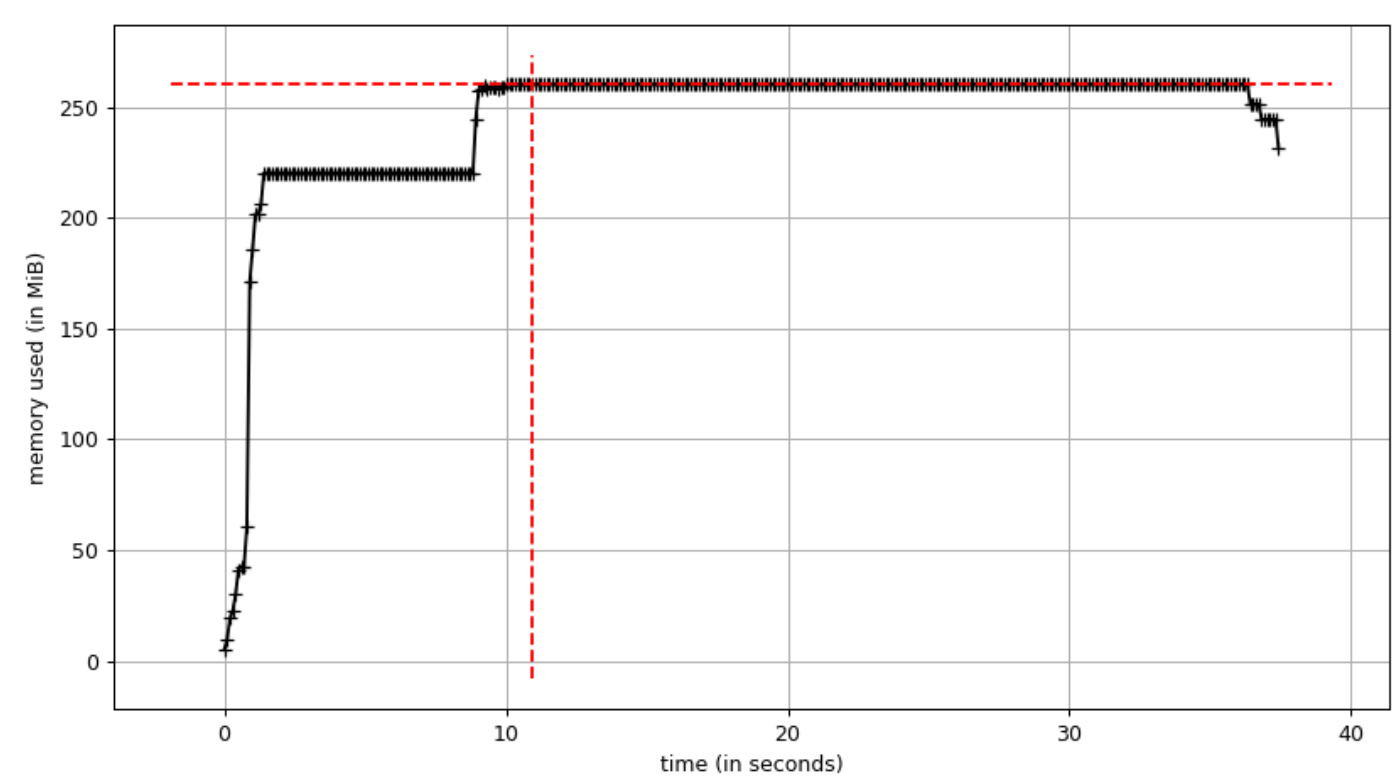

- 全体のメモリを測定します

In [8]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################

import re
import json
import random
import tempfile
import subprocess
import numpy as np
from pathlib import Path
from itertools import islice
from typing import Generator
from collections import Counter, defaultdict

def _generate_3mer(midsv_sample: Generator[dict[str, str]]) -> Generator[str]:
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        cssplits_kmer = []
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == 0:
                two_prior = cs
                cssplits_kmer.append(cs)
                continue
            if idx_seq == 1:
                one_prior = cs
                cssplits_kmer.append(cs)
                continue
            cssplits_kmer.append(two_prior + "," + one_prior + "," + cs)
            two_prior, one_prior = one_prior, cs
        yield cssplits_kmer


def _transpose_by_subprocess(cssplits_3mer_sample: str, output_path:str, chunksize: int = 100, sep: str = "\t") -> Generator:
    # Write cssplits
    with tempfile.NamedTemporaryFile() as fp:
            temp_cssplits = fp.name
    with open(temp_cssplits, "w") as out:
        for cssplits in cssplits_3mer_sample:
            out.write(f"{sep}".join(cssplits) + "\n")
    # Transpose by subprocess
    with tempfile.NamedTemporaryFile() as fp:
        temp_output = fp.name
    with tempfile.NamedTemporaryFile() as fp:
        temp_chunk = fp.name
    with tempfile.NamedTemporaryFile() as fp:
        temp_pasted = fp.name
    with tempfile.NamedTemporaryFile() as fp:
        temp_transposed_cssplits = fp.name
    with open(temp_cssplits, "r") as f:
        while True:
            next_n_lines = [line.strip().split(sep) for line in islice(f, chunksize)]
            if not next_n_lines:
                break
            with open(temp_chunk, "w") as out:
                for line in zip(*next_n_lines):
                    out.write(sep.join(line) + "\n")
            if not Path(temp_output).exists():
                subprocess.call(f"mv {temp_chunk} {temp_output}", shell=True)
            else:
                subprocess.call(f"paste -d '{sep}' {temp_output} {temp_chunk} > {temp_pasted}", shell=True)
                subprocess.call(f"mv {temp_pasted} {temp_output}", shell=True)
        subprocess.call(f"mv {temp_output} {temp_transposed_cssplits}", shell=True)

def _read_cssplits_as_tsv(input_path):
    with open(input_path, "r") as f:
        for line in f:
            yield line.split("\t")

def _sampling_cssplits(transposed_midsv, mutation_loci) -> Generator:
    for idx_seq, cssplits_3mers in enumerate(transposed_midsv):
        sampling_2mer = defaultdict(list)
        if idx_seq == 0 or idx_seq == 1:
            yield defaultdict(Counter)
            continue
        for cssplits_3mer in cssplits_3mers:
            two_prior, one_prior, cs = cssplits_3mer.split(",")
            if cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                previous_2mer = two_prior + "," + one_prior
                sampling_2mer[previous_2mer].append(cs)
            one_prior, two_prior = two_prior, cs
        yield {mer: Counter(samp) for mer, samp in sampling_2mer.items()}


def _correct_errors_cssplits(transposed_midsv, mutation_loci, sampling_cssplits):
    random.seed(1)
    for idx_seq, (cssplits_3mers, sampling_cssplit) in enumerate(zip(transposed_midsv, sampling_cssplits)):
        if idx_seq == 0 or idx_seq == 1:
            yield [cs for cs in cssplits_3mers]
            continue
        cssplits_corrected = []
        for cssplits_3mer in cssplits_3mers:
            two_prior, one_prior, cs = cssplits_3mer.split(",")
            if not (cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs)):
                previous_2mer = f"{two_prior},{one_prior}"
                try:
                    sampling = sampling_cssplit[previous_2mer]
                except KeyError:
                    cs = "N"
                else:
                    cs = random.choices(*zip(*sampling.items()))[0]
            cssplits_corrected.append(cs)
        yield ",".join(cssplits_corrected)


def _combine_with_qname_cssplits(midsv_sample, cssplits_corrected):
    for samp, cssplits in zip(midsv_sample, cssplits_corrected):
        yield {"QNAME": samp["QNAME"], "CSSPLIT": cssplits}

# def read_midsv(filepath) -> Generator[dict[str, str]]:
#     with open(filepath, "r") as f:
#         for line in f:
#             yield json.loads(line)

# ! Read 100 lines
def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            yield json.loads(line)
            if i == 100:
                break

###############################################################################
# main
###############################################################################


def correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES) -> None:
    for allele in FASTA_ALLELES:
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        mutation_loci = MUTATION_LOCI_ALLELES[allele]
        midsv_3mer_sample = _generate_3mer(read_midsv(filepath_sample))
        _transpose_by_subprocess(midsv_3mer_sample, "tmp_transposed.csv", chunksize=100)
        sampling_sample = _sampling_cssplits(_read_cssplits_as_tsv("tmp_transposed.tsv"), mutation_loci)
        cssplits_corrected_sample = _correct_errors_cssplits(_read_cssplits_as_tsv("tmp_transposed.tsv"), mutation_loci, sampling_sample)
        qname_cssplits_sample = _combine_with_qname_cssplits(read_midsv(filepath_sample), cssplits_corrected_sample)
        out_filepath = Path(TEMPDIR, "midsv_corrected", f"{SAMPLE_NAME}_{allele}.json")
        with open(out_filepath, "wt", encoding="utf-8") as f:
            for data in qname_cssplits_sample:
                f.write(json.dumps(data) + "\n")

###############################################################################

if __name__ == "__main__":
    # 引数
    from DAJIN2.core import preprocess
    from pathlib import Path
    import sys

    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    # midsv_sample, midsv_control = prepare_samples()
    # print(f"Read number: {len(midsv_control['control'])}")
    import pickle

    MUTATION_LOCI_ALLELES = pickle.load(open(f"DAJINResults/.tempdir/single-r10/mutation_loci/{SAMPLE_NAME}.plk", "rb"))
    print("execute...", file=sys.stderr)
    correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES)


Overwriting tmp_memory_profile.py


In [9]:
%%bash
export PYTHONPATH=src
time mprof run tmp_memory_profile.py > tmp_memory_profile.txt
mprof plot -o tmp_image.png --backend agg
cat tmp_memory_profile.txt

execute...

real	0m2.087s
user	0m2.018s
sys	0m3.969s


Using last profile data.
mprof: Sampling memory every 0.1s
running new process
running as a Python program...


In [5]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################
import re
import json
import random
import tempfile
import subprocess
import numpy as np
from pathlib import Path
from itertools import islice
from typing import Generator
from collections import Counter, defaultdict

def _generate_3mer(midsv_sample: Generator[dict[str, str]]) -> Generator[str]:
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        cssplits_kmer = []
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == 0:
                two_prior = cs
                cssplits_kmer.append(cs)
                continue
            if idx_seq == 1:
                one_prior = cs
                cssplits_kmer.append(cs)
                continue
            cssplits_kmer.append(two_prior + "," + one_prior + "," + cs)
            two_prior, one_prior = one_prior, cs
        yield cssplits_kmer


def _get_path_of_transposed_matrix(cssplits_sample: str, chunksize: int = 100, sep: str = "\t") -> str:
    # Write cssplits
    with tempfile.NamedTemporaryFile() as fp:
            temp_cssplits = fp.name
    with open(temp_cssplits, "w") as out:
        for cssplits in cssplits_sample:
            out.write(sep.join(cssplits) + "\n")
    # Transpose by subprocess
    with tempfile.NamedTemporaryFile() as fp:
        temp_output = fp.name
    with tempfile.NamedTemporaryFile() as fp:
        temp_transposed_chunk = fp.name
    with tempfile.NamedTemporaryFile() as fp:
        temp_pasted = fp.name
    with tempfile.NamedTemporaryFile() as fp:
        output_path = fp.name
    with open(temp_cssplits, "r") as f:
        while True:
            next_n_lines = [line.strip().split(sep) for line in islice(f, chunksize)]
            if not next_n_lines:
                break
            with open(temp_transposed_chunk, "w") as out:
                for line in zip(*next_n_lines):
                    out.write(sep.join(line) + "\n")
            if not Path(temp_output).exists():
                subprocess.call(f"mv {temp_transposed_chunk} {temp_output}", shell=True)
            else:
                subprocess.call(f"paste -d '{sep}' {temp_output} {temp_transposed_chunk} > {temp_pasted}", shell=True)
                subprocess.call(f"cat {temp_pasted} > {temp_output}", shell=True)
        subprocess.call(f"cat {temp_output} > {output_path}", shell=True)
    return output_path

def _read_cssplits_as_tsv(input_path):
    with open(input_path, "r") as f:
        for line in f:
            yield line.strip().split("\t")

def _sampling_cssplits(transposed_midsv, mutation_loci) -> Generator:
    for idx_seq, cssplits_3mers in enumerate(transposed_midsv):
        sampling_2mer = defaultdict(list)
        if idx_seq == 0 or idx_seq == 1:
            yield defaultdict(Counter)
            continue
        for cssplits_3mer in cssplits_3mers:
            two_prior, one_prior, cs = cssplits_3mer.split(",")
            if cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                previous_2mer = two_prior + "," + one_prior
                sampling_2mer[previous_2mer].append(cs)
            one_prior, two_prior = two_prior, cs
        yield {mer: Counter(samp) for mer, samp in sampling_2mer.items()}


def _correct_errors_cssplits(transposed_midsv, mutation_loci, sampling_cssplits):
    random.seed(1)
    for idx_seq, (cssplits_3mers, sampling_cssplit) in enumerate(zip(transposed_midsv, sampling_cssplits)):
        if idx_seq == 0 or idx_seq == 1:
            yield [cs for cs in cssplits_3mers]
            continue
        cssplits_corrected = []
        for cssplits_3mer in cssplits_3mers:
            two_prior, one_prior, cs = cssplits_3mer.split(",")
            if not (cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs)):
                previous_2mer = f"{two_prior},{one_prior}"
                try:
                    sampling = sampling_cssplit[previous_2mer]
                except KeyError:
                    cs = "N"
                else:
                    cs = random.choices(*zip(*sampling.items()))[0]
            cssplits_corrected.append(cs)
        yield cssplits_corrected


def _combine_with_qname_cssplits(midsv_sample, cssplits_corrected):
    for samp, cssplits in zip(midsv_sample, cssplits_corrected):
        yield {"QNAME": samp["QNAME"], "CSSPLIT": ",".join(cssplits)}

# def read_midsv(filepath) -> Generator[dict[str, str]]:
#     with open(filepath, "r") as f:
#         for line in f:
#             yield json.loads(line)

# ! Read 10000 lines
def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            yield json.loads(line)
            if i == 10000:
                break

###############################################################################
# main
###############################################################################


def correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES) -> None:
    for allele in FASTA_ALLELES:
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        mutation_loci = MUTATION_LOCI_ALLELES[allele]
        midsv_3mer_sample = _generate_3mer(read_midsv(filepath_sample))
        path_transposed = _get_path_of_transposed_matrix(midsv_3mer_sample, chunksize=100)
        sampling_sample = _sampling_cssplits(_read_cssplits_as_tsv(path_transposed), mutation_loci)
        cssplits_corrected_sample = _correct_errors_cssplits(_read_cssplits_as_tsv(path_transposed), mutation_loci, sampling_sample)
        path_transposed_corrected = _get_path_of_transposed_matrix(cssplits_corrected_sample, chunksize=100)
        qname_cssplits_sample = _combine_with_qname_cssplits(read_midsv(filepath_sample), _read_cssplits_as_tsv(path_transposed_corrected))
        out_filepath = Path(TEMPDIR, "midsv_corrected", f"{SAMPLE_NAME}_{allele}.json")
        with open(out_filepath, "wt", encoding="utf-8") as f:
            for data in qname_cssplits_sample:
                f.write(json.dumps(data) + "\n")

if __name__ == "__main__":
    # 引数
    from DAJIN2.core import preprocess
    from pathlib import Path
    import sys

    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    # midsv_sample, midsv_control = prepare_samples()
    # print(f"Read number: {len(midsv_control['control'])}")
    import pickle

    MUTATION_LOCI_ALLELES = pickle.load(open(f"DAJINResults/.tempdir/single-r10/mutation_loci/{SAMPLE_NAME}.plk", "rb"))
    print("execute...", file=sys.stderr)
    print(Path(TEMPDIR, "midsv_corrected", f"{SAMPLE_NAME}_control.json"), file=sys.stderr)
    correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES)

Overwriting tmp_memory_profile.py


In [161]:
%%bash
export PYTHONPATH=src
time mprof run tmp_memory_profile.py > tmp_memory_profile.txt
mprof plot -o tmp_image.png --backend agg
cat tmp_memory_profile.txt

execute...
DAJINResults/.tempdir/single-r10/midsv_corrected/r10_barcode31_control.json

real	1m30.926s
user	0m46.515s
sys	0m16.807s


Using last profile data.
mprof: Sampling memory every 0.1s
running new process
running as a Python program...


- おそらく問題なくできました！
- 10000本のリードに対して、300MB程度のメモリ消費量でした！
- 実行時間も1分30秒程度で、悪くないようです

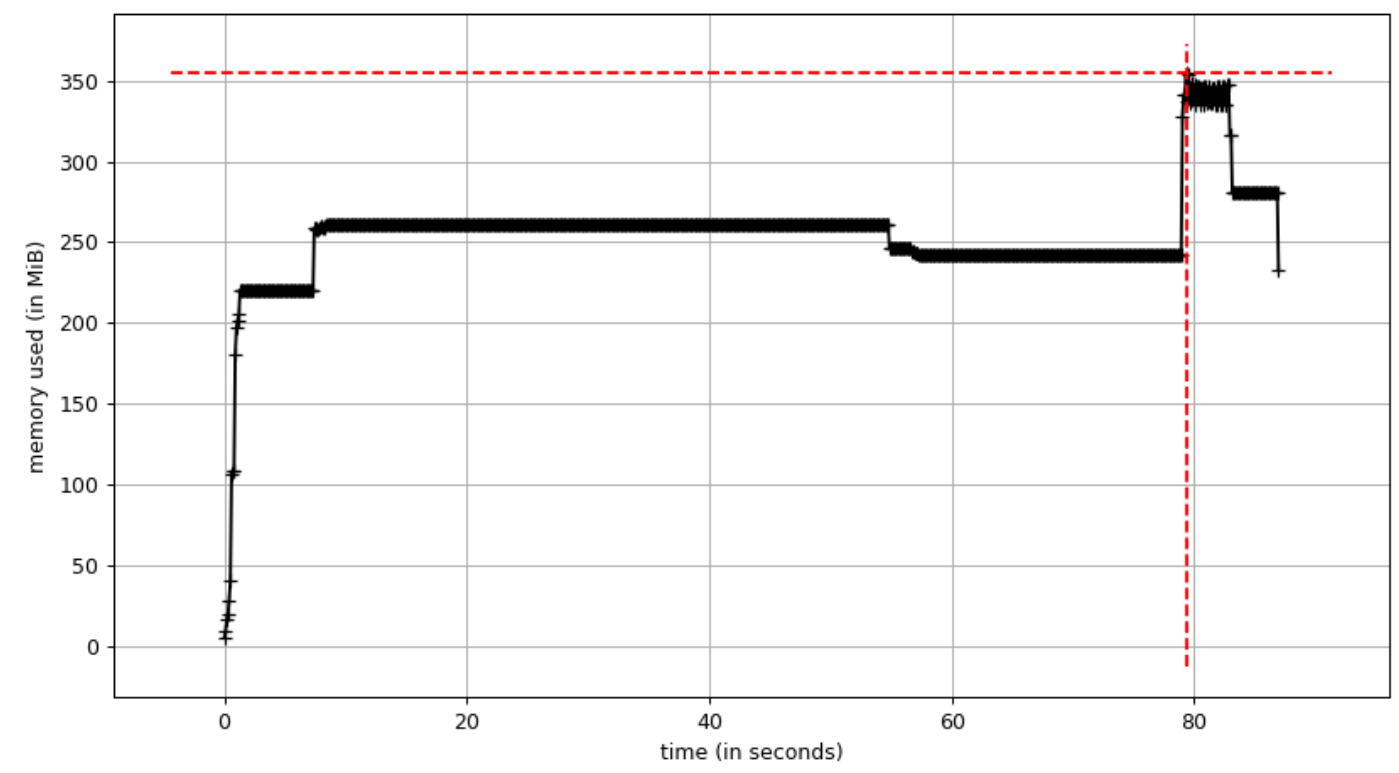

- すべてのリードで行います

In [14]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################
import re
import json
import random
import tempfile
import subprocess
import numpy as np
from pathlib import Path
from itertools import islice
from typing import Generator
from collections import Counter, defaultdict

def _generate_3mer(midsv_sample: Generator[dict[str, str]]) -> Generator[str]:
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        cssplits_kmer = []
        for idx_seq, cs in enumerate(cssplits):
            if idx_seq == 0:
                two_prior = cs
                cssplits_kmer.append(cs)
                continue
            if idx_seq == 1:
                one_prior = cs
                cssplits_kmer.append(cs)
                continue
            cssplits_kmer.append(two_prior + "," + one_prior + "," + cs)
            two_prior, one_prior = one_prior, cs
        yield cssplits_kmer


def _get_path_of_transposed_matrix(cssplits_sample: str, chunksize: int = 100, sep: str = "\t") -> str:
    # Write cssplits
    with tempfile.NamedTemporaryFile() as fp:
            temp_cssplits = fp.name
    with open(temp_cssplits, "w") as out:
        for cssplits in cssplits_sample:
            out.write(sep.join(cssplits) + "\n")
    # Transpose by subprocess
    with tempfile.NamedTemporaryFile() as fp:
        temp_output = fp.name
    with tempfile.NamedTemporaryFile() as fp:
        temp_transposed_chunk = fp.name
    with tempfile.NamedTemporaryFile() as fp:
        temp_pasted = fp.name
    with tempfile.NamedTemporaryFile() as fp:
        output_path = fp.name
    with open(temp_cssplits, "r") as f:
        while True:
            next_n_lines = [line.strip().split(sep) for line in islice(f, chunksize)]
            if not next_n_lines:
                break
            with open(temp_transposed_chunk, "w") as out:
                for line in zip(*next_n_lines):
                    out.write(sep.join(line) + "\n")
            if not Path(temp_output).exists():
                subprocess.call(f"mv {temp_transposed_chunk} {temp_output}", shell=True)
            else:
                subprocess.call(f"paste -d '{sep}' {temp_output} {temp_transposed_chunk} > {temp_pasted}", shell=True)
                subprocess.call(f"cat {temp_pasted} > {temp_output}", shell=True)
        subprocess.call(f"cat {temp_output} > {output_path}", shell=True)
    return output_path

def _read_cssplits_as_tsv(input_path):
    with open(input_path, "r") as f:
        for line in f:
            yield line.strip().split("\t")

def _sampling_cssplits(transposed_midsv, mutation_loci) -> Generator:
    for idx_seq, cssplits_3mers in enumerate(transposed_midsv):
        sampling_2mer = defaultdict(list)
        if idx_seq == 0 or idx_seq == 1:
            yield defaultdict(Counter)
            continue
        for cssplits_3mer in cssplits_3mers:
            two_prior, one_prior, cs = cssplits_3mer.split(",")
            if cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                previous_2mer = two_prior + "," + one_prior
                sampling_2mer[previous_2mer].append(cs)
            one_prior, two_prior = two_prior, cs
        yield {mer: Counter(samp) for mer, samp in sampling_2mer.items()}


def _correct_errors_cssplits(transposed_midsv, mutation_loci, sampling_cssplits):
    random.seed(1)
    for idx_seq, (cssplits_3mers, sampling_cssplit) in enumerate(zip(transposed_midsv, sampling_cssplits)):
        if idx_seq == 0 or idx_seq == 1:
            yield [cs for cs in cssplits_3mers]
            continue
        cssplits_corrected = []
        for cssplits_3mer in cssplits_3mers:
            two_prior, one_prior, cs = cssplits_3mer.split(",")
            if not (cs[0] in mutation_loci[idx_seq] or cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs)):
                previous_2mer = f"{two_prior},{one_prior}"
                try:
                    sampling = sampling_cssplit[previous_2mer]
                except KeyError:
                    cs = "N"
                else:
                    cs = random.choices(*zip(*sampling.items()))[0]
            cssplits_corrected.append(cs)
        yield cssplits_corrected


def _combine_with_qname_cssplits(midsv_sample, cssplits_corrected):
    for samp, cssplits in zip(midsv_sample, cssplits_corrected):
        yield {"QNAME": samp["QNAME"], "CSSPLIT": ",".join(cssplits)}

def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)

# # ! Read 10000 lines
# def read_midsv(filepath) -> Generator[dict[str, str]]:
#     with open(filepath, "r") as f:
#         for i, line in enumerate(f):
#             yield json.loads(line)
#             if i == 10000:
#                 break

###############################################################################
# main
###############################################################################


def correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES) -> None:
    for allele in FASTA_ALLELES:
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        mutation_loci = MUTATION_LOCI_ALLELES[allele]
        midsv_3mer_sample = _generate_3mer(read_midsv(filepath_sample))
        path_transposed = _get_path_of_transposed_matrix(midsv_3mer_sample, chunksize=100)
        sampling_sample = _sampling_cssplits(_read_cssplits_as_tsv(path_transposed), mutation_loci)
        cssplits_corrected_sample = _correct_errors_cssplits(_read_cssplits_as_tsv(path_transposed), mutation_loci, sampling_sample)
        path_transposed_corrected = _get_path_of_transposed_matrix(cssplits_corrected_sample, chunksize=100)
        qname_cssplits_sample = _combine_with_qname_cssplits(read_midsv(filepath_sample), _read_cssplits_as_tsv(path_transposed_corrected))
        out_filepath = Path(TEMPDIR, "midsv_corrected", f"{SAMPLE_NAME}_{allele}.json")
        with open(out_filepath, "wt", encoding="utf-8") as f:
            for data in qname_cssplits_sample:
                f.write(json.dumps(data) + "\n")

if __name__ == "__main__":
    # 引数
    from DAJIN2.core import preprocess
    from pathlib import Path
    import sys

    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    # midsv_sample, midsv_control = prepare_samples()
    # print(f"Read number: {len(midsv_control['control'])}")
    import pickle

    MUTATION_LOCI_ALLELES = pickle.load(open(f"DAJINResults/.tempdir/single-r10/mutation_loci/{SAMPLE_NAME}.plk", "rb"))
    print("execute...", file=sys.stderr)
    print(Path(TEMPDIR, "midsv_corrected", f"{SAMPLE_NAME}_control.json"), file=sys.stderr)
    correct_sequence_error(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES)

Overwriting tmp_memory_profile.py


In [15]:
%%bash
export PYTHONPATH=src
time mprof run tmp_memory_profile.py > tmp_memory_profile.txt
mprof plot -o tmp_image.png --backend agg
cat tmp_memory_profile.txt

execute...
DAJINResults/.tempdir/single-r10/midsv_corrected/r10_barcode31_control.json

real	7m27.756s
user	2m46.982s
sys	1m22.993s


Using last profile data.
mprof: Sampling memory every 0.1s
running new process
running as a Python program...


- 7分30秒ほどかかりましたが、メモリは最大でも500MB程度の消費に抑えることができていました！
    - もともと12GBも消費していたので、これは大きな進歩かと思います

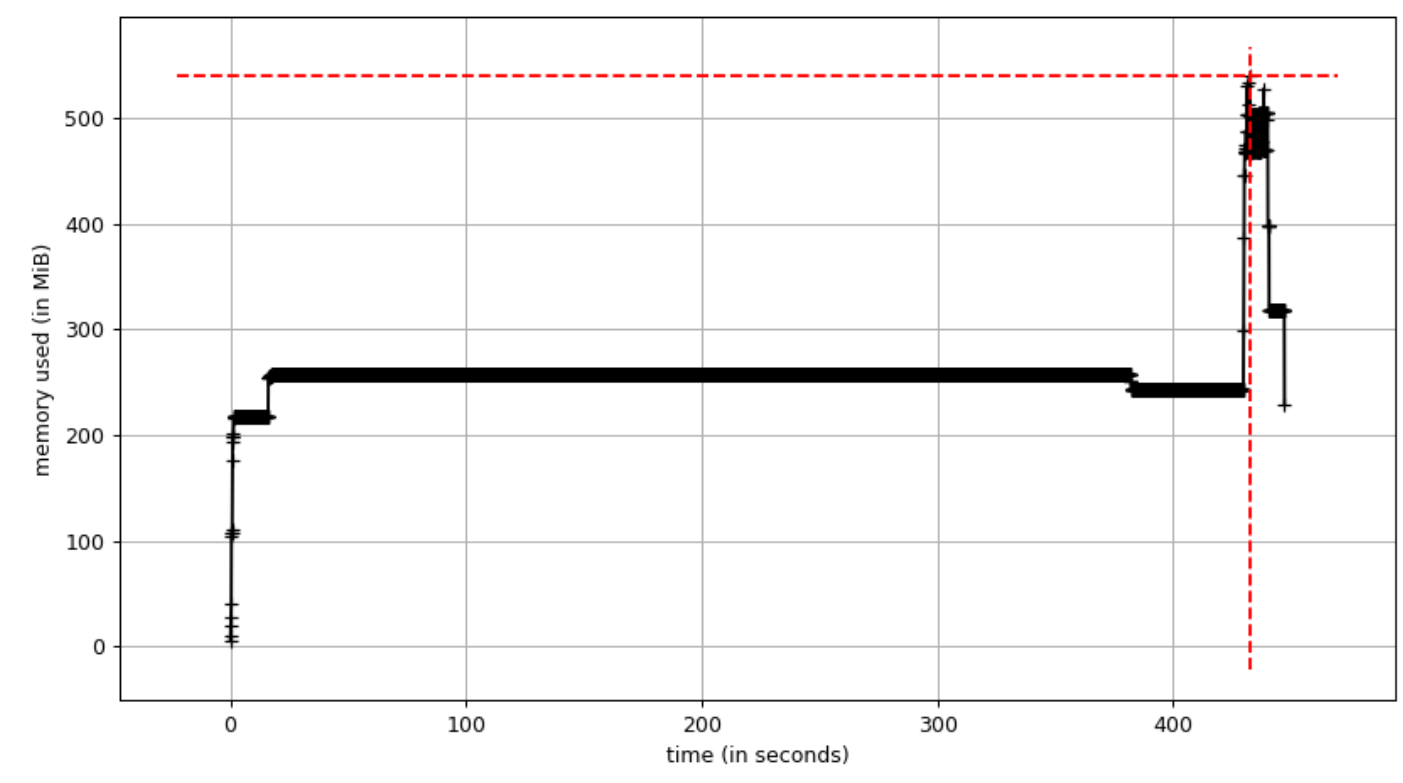

- correct後の変異を確認します
    - 理想は、828位置以外の点変異がないことです

In [16]:
from collections import defaultdict
import json
def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)

path_sample = Path("DAJINResults/.tempdir/single-r10/midsv_corrected/r10_barcode31_control.json")

count = defaultdict(int)
for samp in read_midsv(path_sample):
    cssplits = samp["CSSPLIT"].split(",")
    count[cssplits[828]] += 1

print(count)
print(sum(count.values()))

defaultdict(<class 'int'>, {'*GT': 18760, '=G': 1092, '*GC': 979, '-G': 2641, '*GA': 65, 'N': 913, '=g': 3})
24453


In [17]:
from collections import defaultdict
import json
def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)

path_sample = Path("DAJINResults/.tempdir/single-r10/midsv/r10_barcode31_control.json")

count = defaultdict(int)
for samp in read_midsv(path_sample):
    cssplits = samp["CSSPLIT"].split(",")
    count[cssplits[828]] += 1

print(count)
print(sum(count.values()))

defaultdict(<class 'int'>, {'*GT': 18455, '=G': 1083, '*GC': 967, '-G': 2600, '+T|*GT': 168, '*GA': 63, '+T|+A|=G': 21, 'N': 912, '+T|*GA': 1, '=g': 3, '+T|=G': 10, '+T|+T|*GT': 47, '+T|+T|=G': 12, '+C|+T|*GC': 2, '+T|*GC': 36, '+T|+T|*GC': 20, '+T|+C|+A|=G': 1, '+C|+T|*GT': 4, '+T|+C|+T|*GT': 3, '+T|+A|*GT': 5, '+A|*GC': 4, '+A|+T|*GT': 9, '+A|+T|+T|*GC': 1, '+T|+T|+T|*GT': 3, '+T|+T|+T|=G': 1, '+T|+G|=G': 2, '+T|+T|+G|=G': 3, '+T|+T|+A|+G|=G': 1, '+A|+G|+G|=G': 1, '+A|=G': 4, '+T|+T|+A|=G': 3, '+T|+A|+T|*GT': 1, '+C|+T|=G': 1, '+G|+T|=G': 1, '+G|+T|+G|=G': 1, '+T|+A|+T|=G': 1, '+A|+C|+T|*GT': 1, '+A|+A|+T|+T|+T|*GT': 1, '+A|+T|=G': 1})
24453


- かなりシークエンスエラーが抑えられているようです

- R10のサンプルでマルチプロセスを行っていますが、2時間立っても終了せずに困っています…
- 時間がかかりすぎるのは良くないので、対応を考えます
- やはり明示的に変異を補正するのではなくて、変異の箇所を必要なときにマスクする、といった形で対応しようかと考えています

# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- `correct_sequence_error`はメモリ対策をしましたが、実行時間がそうとう長くなってしまいました
- コードを改善するよりも、抜本的に変更したほうが良さそうです
- 明示的に補正するよりも、必要になった段階で`mutation_loci`を呼び出してその都度補正していく、といった形ができればと思います

# 次に取り組むこと

- メモリを節約します
    - ✅ `calc_midsv`
    - ✅ `extract_mutation_loci`
    - ⬜ `correct_sequence_error`
    - ⬜ `classify`
    - ⬜ `clustaring`
    - ⬜ `consensus`
    - ⬜ `report`

### Lists

+ GUIの見栄え
+ igv.jsの起動
+ VCFによる長鎖挿入・欠失情報の付与
+ Figの作成
+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
+ ✅ Tyrの動作確認
+ ✅ ayabe-task1のleft/right-loxpの検出
+ ✅ mutation_lociをpreprocessで使用したものに変更する
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする